# CITS4402 Project: Normalisation Technique Ablation Study

### Group Members:

- Jalil Inayat-Hussain (22751096)
- Felix Mavrodoglu (23720305)
- Reilly Evans (23615971)

We will begin this ablation study by training a SVM model on the Histogram of Oriented Gradients (HOG) features of the INRIA training and testing datasets. The training set contains 3600 images (1800 human and 1800 non-human), while the testing set contains 900 images (450 human and 450 non-human). All hyperparameters for the HOG feature extraction (including the normalisation technique hyperparameter, which this study focuses on) will be set to the initial values described in the project task statement:

- Preprocessing: No gamma correction
- Gradient Computation: [-1, 0, 1] filter without smoothing
- Orientation Binning: 9 bins
- Cell Size: 8×8 pixels
- Block Size: 16×16 pixels
- Block Normalization: L2-Hys normalization (Lowe-style clipped L2 norm)
- Block Stride: 8-pixel spacing (4-fold coverage of each cell)
- Detection Window Size: 64×128 pixels
- Classifier: Linear SVM

Additionally, the random seed shall be set for each feature extraction and SVM model in this notebook, to ensure results are comparable and reproducible. 

In [1]:
# Import project functions, file management, time measuring
from projectFunctions import formatDataset
import os
import time

# Define file paths to training/testing set data
trainDataset = './ExampleSets/INRIAFullDataset/INRIAFullTrain.tar.gz'
testDataset = './ExampleSets/INRIAFullDataset/INRIAFullTest.tar.gz'

# Make folder to save graphs to if it doesn't exist already
graphFolder = './Images'
if not os.path.isdir(graphFolder): os.mkdir(graphFolder)

# Define dictionaries to store dataset details
(
    modelTrainFeatures, modelTrainLabels, 
    modelTestFeatures, modelTestLabels, modelStartTime
) = ({}, {}, {}, {}, {})

# Get the HOG features from the data with default parameters
# formatDataset() has the desired parameters as defaults already, 
# so we do not need to specify most of them
print('Calculating HOG features with default parameters...')
modelStartTime['L2-Hys'] = time.time()
(
    _, modelTrainFeatures['L2-Hys'], modelTrainLabels['L2-Hys']
) = formatDataset(trainDataset, deleteDir = True, randomSeed = 48)
(
    _, modelTestFeatures['L2-Hys'], modelTestLabels['L2-Hys']
) = formatDataset(testDataset, deleteDir = True, randomSeed = 48)
print((
    'Default HOG features calculated; elapsed time = '
    f'{time.time() - modelStartTime["L2-Hys"]:.2f} seconds'
))

Calculating HOG features with default parameters...
Default HOG features calculated; elapsed time = 14.80 seconds


An SVM model will now be trained on the extracted HOG features, with the random state set to ensure reproducibility. Other parameters will be left at their default values to avoid influencing the ablation study's results. Once the model is trained, we will calculate the accuracy, precision, recall, F1 score and area under the ROC curve (AUC) for it on the testing set, alongside generating the confusion matrix for the model. This allows for detailed comparisons of the model performance once additional models have been trained.

In [2]:
# Import SVM model class and performance score functions
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Define more dictionaries to store model details
(
    modelSVM, modelPredicts, modelDecisions, modelAccuracy, 
    modelPrecision, modelRecall, modelF1, modelAUC
) = ({}, {}, {}, {}, {}, {}, {}, {})

# Create and train SVM classifier
modelSVM['L2-Hys'] = LinearSVC(random_state = 48)
modelSVM['L2-Hys'].fit(
    modelTrainFeatures['L2-Hys'], modelTrainLabels['L2-Hys']
)

# Get predictions and decision function on the testing set
modelPredicts['L2-Hys'] = modelSVM['L2-Hys'].predict(
    modelTestFeatures['L2-Hys']
)
modelDecisions['L2-Hys'] = modelSVM['L2-Hys'].decision_function(
    modelTestFeatures['L2-Hys']
)

# Use iterator to calculate performance metrics with predictions
scoreFunctions = tuple(zip(
    (modelAccuracy, modelPrecision, modelRecall, modelF1),
    (accuracy_score, precision_score, recall_score, f1_score)
))
for score, fn in scoreFunctions:
    score['L2-Hys'] = fn(
        modelTestLabels['L2-Hys'], modelPredicts['L2-Hys']
    )
modelAUC['L2-Hys'] = roc_auc_score(
    modelTestLabels['L2-Hys'], modelDecisions['L2-Hys']
)

# Display performance metrics
print((
    'Performance Scores on INRIA Testing Dataset '
    'with Default Parameters:'
))
print(f'Accuracy:  {modelAccuracy["L2-Hys"]:.6}')
print(f'Precision: {modelPrecision["L2-Hys"]:.6}')
print(f'Recall:    {modelRecall["L2-Hys"]:.6}')
print(f'F1 Score:  {modelF1["L2-Hys"]:.6}')
print(f'AUC:       {modelAUC["L2-Hys"]:.6}')

Performance Scores on INRIA Testing Dataset with Default Parameters:
Accuracy:  0.965556
Precision: 0.964523
Recall:    0.966667
F1 Score:  0.965594
AUC:       0.99557


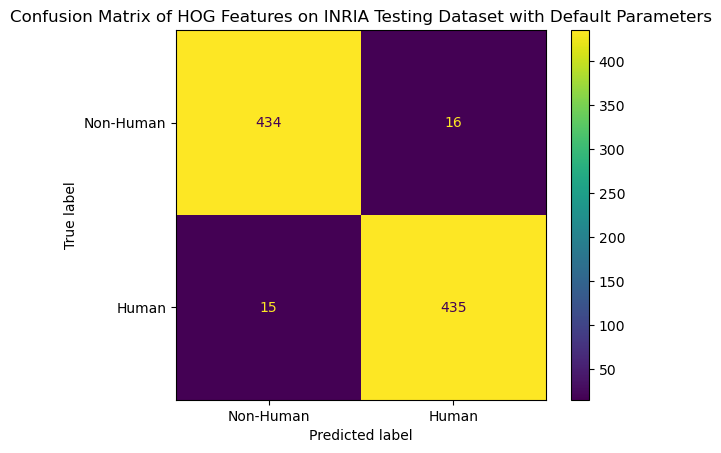

In [3]:
# Import confusion matrix and matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display confusion matrix for default parameter model
ConfusionMatrixDisplay.from_predictions(
    modelTestLabels["L2-Hys"], modelPredicts["L2-Hys"],
    display_labels = ['Non-Human', 'Human']
)

plt.title((
    'Confusion Matrix of HOG Features on INRIA '
    'Testing Dataset with Default Parameters'
))
plt.show()

The scores and confusion matrix show that the default normalisation technique already results in a high-performance model. Further analysis will be done once models have been trained for the other possible techniques.

The default HOG parameters use L2-Hys (short for hysteresis) normalisation, which applies Lowes-style clipping to the Euclidean norm before recalculating the norm with the clipped values. The scikit-image `hog()` function used for our feature extraction allows for 3 additional normalisation techniques:

- L1 (Manhattan norm with no additional processing)
- L1-sqrt (Square root of Manhattan norm)
- L2 (Euclidean norm with no additional processing)

We will now fit 3 additional SVM models using HOG features generated with these normalisation techniques. Besides the technique, all other parameters (including the random seed) will be set to the same values as the base model, ensuring that no additional factors affect the results.

In [4]:
# Define list of potential normalisation techniques
normTechniques = ('L1', 'L1-sqrt', 'L2', 'L2-Hys')

# Get features with different normalisation techniques
for norm in normTechniques[:-1]: # L2-Hys is already calculated
    print(f'Calculating HOG features with {norm} normalisation...')
    modelStartTime[norm] = time.time()
    (_, modelTrainFeatures[norm], modelTrainLabels[norm]) = formatDataset(
        trainDataset, deleteDir = True, randomSeed = 48, 
        normalisationTechnique = norm
    )
    (_, modelTestFeatures[norm], modelTestLabels[norm]) = formatDataset(
        testDataset, deleteDir = True, randomSeed = 48, 
        normalisationTechnique = norm
    )
    print((
        f'{norm} HOG features calculated; elapsed time = '
        f'{time.time() - modelStartTime[norm]:.2f} seconds'
    ))

Calculating HOG features with L1 normalisation...
L1 HOG features calculated; elapsed time = 13.39 seconds
Calculating HOG features with L1-sqrt normalisation...
L1-sqrt HOG features calculated; elapsed time = 14.41 seconds
Calculating HOG features with L2 normalisation...
L2 HOG features calculated; elapsed time = 13.93 seconds


With the new HOG features calculated, we will train models on each one and calculate the same performance metrics that were used for the base model. Additionally, we will use a pandas DataFrame to display these metrics in a single, easily understood table.

In [5]:
# Import pandas for DataFrame structure
import pandas as pd

# Train models and calculate performance metrics for each technique
for norm in normTechniques[:-1]:
    modelSVM[norm] = LinearSVC(random_state = 48)
    modelSVM[norm].fit(modelTrainFeatures[norm], modelTrainLabels[norm])
    modelPredicts[norm] = modelSVM[norm].predict(modelTestFeatures[norm])
    modelDecisions[norm] = modelSVM[norm].decision_function(
        modelTestFeatures[norm]
    )
    for score, fn in scoreFunctions:
        score[norm] = fn(modelTestLabels[norm], modelPredicts[norm])
    modelAUC[norm] = roc_auc_score(
        modelTestLabels[norm], modelDecisions[norm]
    )

# Compile performance metrics into DataFrame
scoreTypes = ('Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC')
modelScores = pd.DataFrame(
    (modelAccuracy, modelPrecision, modelRecall, modelF1, modelAUC), 
    index = scoreTypes, columns = normTechniques
).T

# Label L2-Hys technique as default
modelScores.index = modelScores.index[:-1].tolist() + ['L2-Hys (Default)']

# Display DataFrame with caption
modelScores.style.set_caption((
    'Performance Scores of HOG Features on INRIA Testing '
    'Dataset With Different Normalisation Techniques'
))

,Accuracy,Precision,Recall,F1 Score,AUC
L1,0.962222,0.952174,0.973333,0.962637,0.994010
L1-sqrt,0.964444,0.956332,0.973333,0.964758,0.995151
L2,0.955556,0.951542,0.960000,0.955752,0.993126
L2-Hys (Default),0.965556,0.964523,0.966667,0.965594,0.995570


These results show several patterns in the scores of the models for each normalisation technique:
- The L2 model without hysteresis performs the worst out of all the models, having the lowest scores in all 4 performance metrics.
- In terms of recall score, the two L1 models (with and without square-rooting) were tied for the highest score at 0.9733, while the default L2-Hys model scored 0.9667. Recall scores were higher than precision scores for all 4 models.
- For the remaining 4 performance metrics (accuracy, precision, F1 score and AUC), the default L2-Hys model performed the best, scoring 0.9656 in accuracy, 0.9645 in precision, 0.9656 in F1 and 0.9956 in AUC. The L1-sqrt model was second place for each of these scores; the scores are fairly close for accuracy, F1 score and AUC, but in precision the difference between L2-Hys and L1-sqrt is noticeably greater.

AUC will be discussed further once the ROC curves themselves have been plotted. 

To get a better understanding of the model performances and possibly understand the reason for the patterns observed in them, we will now plot confusion matrices for each model.

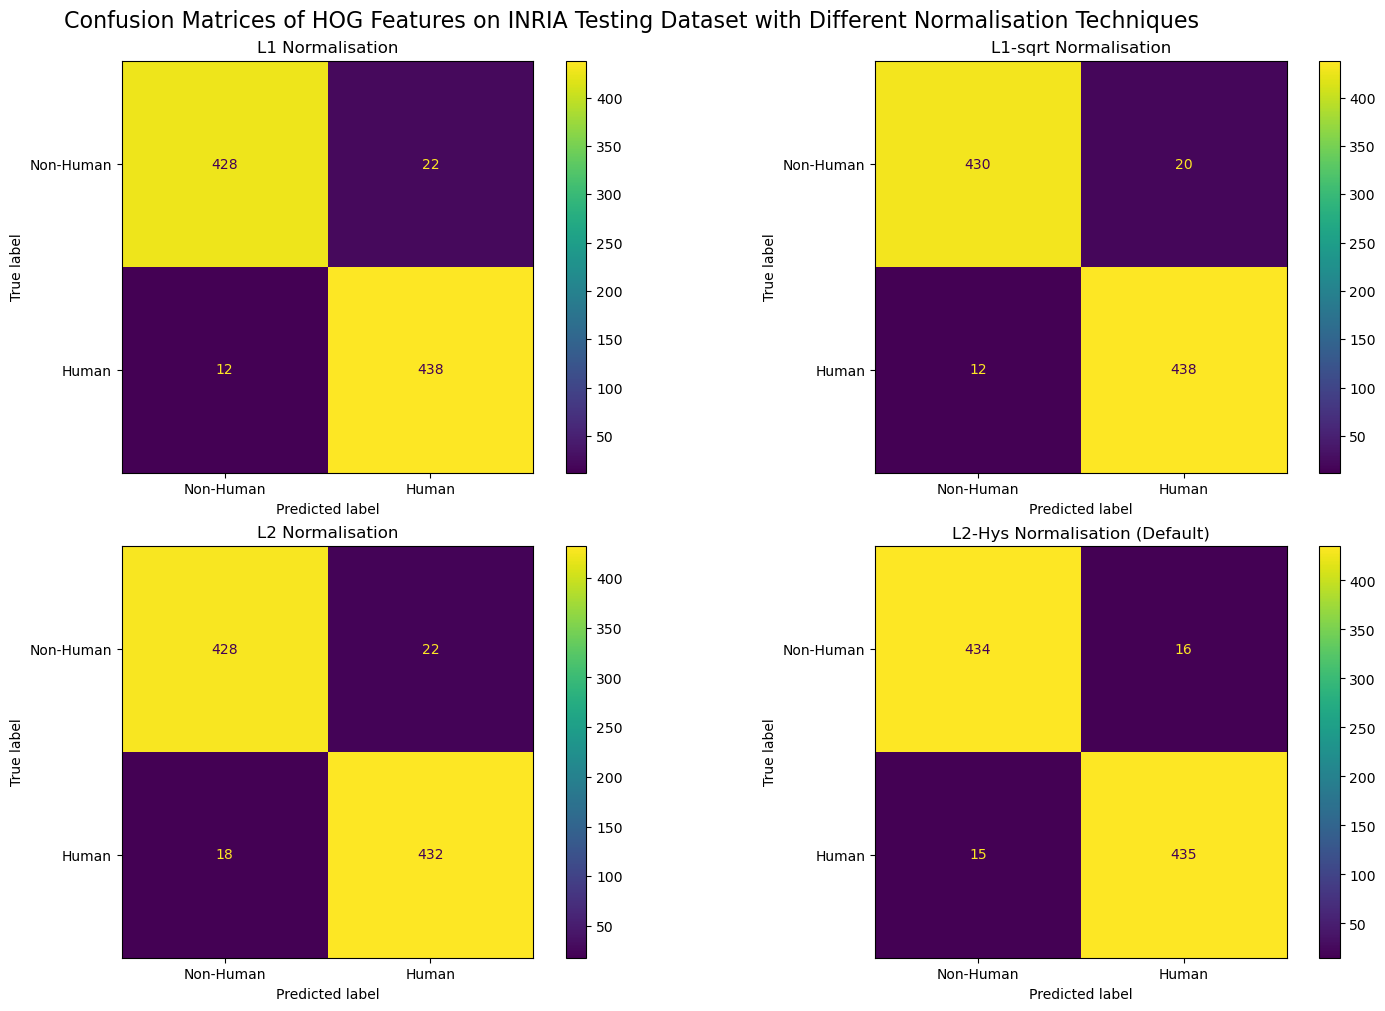

In [6]:
# Initialise confusion matrix figure
confusionFigure, confusionAxes = plt.subplots(
    nrows = 2, ncols = 2, figsize = (15,10), constrained_layout = True
)

# Generate confusion matrices for each normalisation technique
for norm, axis in zip(normTechniques, confusionAxes.flatten()):
    ConfusionMatrixDisplay.from_predictions(
        modelTestLabels[norm], modelPredicts[norm],
        ax = axis, display_labels = ['Non-Human', 'Human']
    )
    axis.set_title(f'{norm} Normalisation')

# Label L2-Hys matrix as default
confusionAxes[1, 1].set_title('L2-Hys Normalisation (Default)')

# Set figure title
confusionFigure.suptitle(
    'Confusion Matrices of HOG Features on INRIA Testing Dataset '
    'with Different Normalisation Techniques', fontsize = 16
)

# Save matrices as image
plt.savefig(os.path.join(graphFolder, 'norm_matrices.png'))

# Display confusion matrices
plt.show()

These confusion matrices reflect many of the observed patterns from the previous performance metrics.

- The L1 and L2 models both made 428 correct non-human predictions out of the 450 negative instances in the testing set. The L1-sqrt model did better with 430 true negatives, while the L2-Hys model was even better with 434 true negatives.
- For positive/human examples, the L1 and L1-sqrt models predicted 438 of the 450 human examples correctly. The L2-Hys model only predicted 435 accurately, while the L2 model predicted just 432 accurately.
- All 4 models predicted more examples as human than as non-human. The L1 model's predictions were the most skewed at 51.11% human, followed by L1-sqrt at 50.89%, L2 at 50.44% and finally L2-Hys at the most balanced 50.11% human. The reasons for this skew likely stem from the dataset itself; some of the images labelled as negative/non-human in the INRIA dataset still contain humans (albeit smaller/further in the background compared to the images labelled as positive/human), so the models may have classified those images as human and skewed their scores as a result.
- The L2-Hys model generates the least false positives, while the L1 and L1-sqrt models generate the least false negatives, as is to be expected from their precision and recall scores.

We will now gauge the effects of the performance metrics using Reciever Operating Characteristic (ROC) curves and Detection Error Tradeoff (DET) curves. ROC curves plot true positive rate (a.k.a. recall) on the y-axis against false positive rate (a.k.a. FPR, calculated as false positives / all negative instances) on the x-axis; DET curves replace true positive rate with false negative rate (a.k.a. miss rate, calculated as 1 - recall) on the y-axis but still use FPR on the x-axis; they also typically use a logarithmic scale instead of a linear one. In the paper linked with the project task statement, the authors use false positives per window (FPPW) for the DET curves rather than false positive rate; however, since our HOG feature extraction only uses 1 window for each instance this is equivalent to false positive rate for our models. We will also calculate the exact area under the ROC curve (AUC) for each model, since this is another useful metric for binary classifier performance.

Area under ROC Curve for Different Normalisation Techniques:
L1:               0.99401
L1-sqrt:          0.995151
L2:               0.993126
L2-Hys (Default): 0.99557


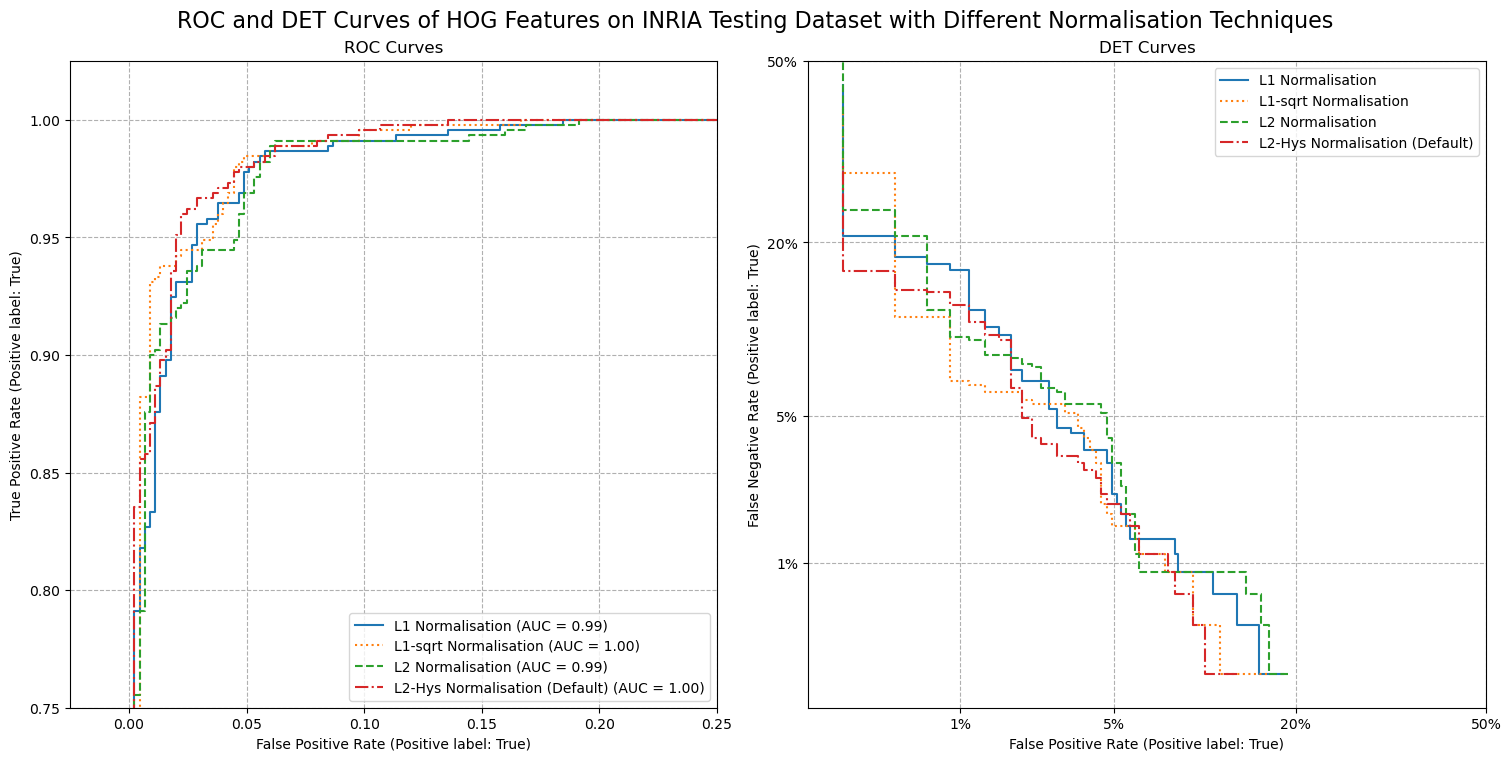

In [7]:
# Import ROC and DET curve functions
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Initialise curve figure
curveFigure, curveAxes = plt.subplots(
    1, 2, figsize = (15,7.5), constrained_layout = True
)

# Generate ROC and DET curves for each normalisation technique
modelStyles = {'L1': '-', 'L1-sqrt': ':', 'L2': '--', 'L2-Hys': '-.'}
for axis, fn in zip(curveAxes, (RocCurveDisplay, DetCurveDisplay)):
    for norm in normTechniques:
        fn.from_estimator(
            modelSVM[norm], modelTestFeatures[norm], 
            modelTestLabels[norm], linestyle = modelStyles[norm],
            name = f'{norm} Normalisation', ax = axis
        )
    
    # Add grid lines to graph
    axis.grid(linestyle = "--")
    
    # Modify legend to avoid curve and label L2-Hys matrix as default
    labels = axis.get_legend_handles_labels()[1]
    labels[-1] = labels[-1].replace(
        'Normalisation', 'Normalisation (Default)'
    )
    axis.legend(
        labels = labels, 
        loc = 'upper right' if fn is DetCurveDisplay else 'lower right'
    )

# Add titles and adjust limits for each axis
curveAxes[0].set_title('ROC Curves')
curveAxes[0].set_xlim([-0.025, 0.25])
curveAxes[0].set_ylim([0.75, 1.025])

curveAxes[1].set_title('DET Curves')
curveAxes[1].set_xlim([-3, 0])
curveAxes[1].set_ylim([-3, 0])

# Set figure title
curveFigure.suptitle(
    'ROC and DET Curves of HOG Features on INRIA Testing Dataset '
    'with Different Normalisation Techniques', fontsize = 16
)

# Save curves as image
plt.savefig(os.path.join(graphFolder, 'norm_curves.png'))

# Display ROC and DET curves
plt.show

# Display area under ROC curve again
print('Area under ROC Curve for Different Normalisation Techniques:')
print(f'L1:               {modelAUC["L1"]:.6}')
print(f'L1-sqrt:          {modelAUC["L1-sqrt"]:.6}')
print(f'L2:               {modelAUC["L2"]:.6}')
print(f'L2-Hys (Default): {modelAUC["L2-Hys"]:.6}')

The ROC and DET curves provide more insight into the performance of these classifiers. Generally, better classifiers will tend closer to the top-left corner of a ROC graph, indicating high recall and low FPR. The ROC curve shows that the L2-Hys model extends the closest to the ROC graph's corner, indicating that it is capable of the best balance between the two rates. Conversely, the L1-sqrt and L2 models appear to perform the best when there is a slight difference between recall and (1 - FPR); these two model curves appear above the L2-Hys curve on either side of the graph's diagonal, but perform noticeably worse when the two metrics are roughly equal. The L2-Hys model has the highest area under the ROC curve, closely followed by the L1-sqrt model.

Unlike ROC curves, DET curves indicate high-performance models by which curves tend closest to the bottom-left corner, indicating both low false negative/miss rate and low FPR. While the linear-scale ROC curve was not noticeably skewed towards either of the metrics it plotted, the logarithmic scale of the DET curve shows that the models on the INRIA dataset are skewed towards lower false positive rates; none of the curves extend beyond 20% false positives, despite miss rate going as high as 50%. The models themselves rank roughly the same as they did on the ROC curve; the L2-Hys model is closest to the bottom-left corner when the axes are equal, while the L1-sqrt model does better when FPR is lower than miss rate.

Once all of these factors are taken into account, overall I believe that the normalisation technique we should use for our model is the L2-Hys norm. Despite being the default normalisation technique, the model trained using L2-Hys had the highest accuracy, precision, F1 score and AUC out of the 4 models we examined. While the L1-sqrt model did provide higher recall than L2-Hys, its lower precision and greater bias towards human examples means that the L2-Hys model will ultimately achieve more consistent results, optimising our model's overall performance.